# Анализ данных из файла Doctor.xlsx


1. Описательная статистика.
2. Создание категориальной переменной.
3. Построение логистической регрессии.
4. Проверка значимости модели и её коэффициентов.
5. Построение доверительных интервалов.
6. Сравнение логит и пробит моделей.
7. Анализ классификационной таблицы.
8. Построение ROC-кривой.
9. Улучшение модели с помощью AIC.


In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.discrete.discrete_model import Probit
import matplotlib.pyplot as plt

# Загрузка данных
file_path = "data/Doctor.xlsx"  # Укажите путь к вашему файлу
data = pd.read_excel(file_path)

# Просмотр данных
data.head()


,y,x1,x2,x3,x4,x5
0,0,14,4.30,1.00,2,3.72
1,0,12,11.54,8.49,3,40.28
2,0,14,5.84,2.47,3,56.00
3,1,11,14.70,6.60,1,57.41
4,0,21,5.10,3.48,1,83.00


## 1. Описательная статистика

In [3]:

# Описательная статистика
data.describe()


,y,x1,x2,x3,x4,x5
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.637931,16.327586,10.327931,7.141379,2.344828,45.135000
std,0.484796,3.213939,3.957742,3.749343,0.928151,53.956171
min,0.000000,11.000000,3.300000,1.000000,1.000000,0.800000
25%,0.000000,14.000000,6.375000,3.985000,1.000000,22.115000
50%,1.000000,16.000000,10.450000,6.835000,3.000000,38.935000
75%,1.000000,19.000000,13.400000,9.975000,3.000000,53.125000
max,1.000000,27.000000,19.000000,16.000000,3.000000,399.800000


## 2. Создание категориальной переменной

In [4]:

# Преобразование переменной Y в категориальную (если необходимо)
data['y'] = data['y'].astype('category')


## 3. Построение логистической регрессии

In [5]:

# Подготовка данных
X = data[['x1', 'x2', 'x3', 'x4', 'x5']]
y = data['y']
X_const = add_constant(X)  # Добавляем константу

# Построение модели
logit_model = sm.Logit(y, X_const)
logit_result = logit_model.fit()

# Вывод результатов
print(logit_result.summary())


Optimization terminated successfully.
         Current function value: 0.341788
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   58
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.4779
Time:                        09:55:47   Log-Likelihood:                -19.824
converged:                       True   LL-Null:                       -37.967
Covariance Type:            nonrobust   LLR p-value:                 8.325e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9423      3.871     -2.827      0.005     -18.529      -3.356
x1             0.4555      0.

## 4. Уравнение регрессии

In [6]:

# Коэффициенты модели
coefficients = logit_result.params
equation = "Logit(Y) = " + " + ".join([f"{coef:.3f}*{col}" for col, coef in coefficients.items()])
sigmoid = "1 / (1 + exp(-Logit(Y)))"
print("Уравнение регрессии:")
print(equation)
print("Сигмоидная функция:")
print(sigmoid)


Уравнение регрессии:
Logit(Y) = -10.942*const + 0.455*x1 + 0.809*x2 + -0.356*x3 + 0.126*x4 + -0.032*x5
Сигмоидная функция:
1 / (1 + exp(-Logit(Y)))


## 5. Тест значимости коэффициентов

In [7]:

# Тест значимости каждого коэффициента
print(logit_result.pvalues)

#sm.Logit.pvalues проводит тест на значимость коэффициентов, нулевая гипотеза которого заключается в том, что коэффициент равен нулю.

const    0.004699
x1       0.011451
x2       0.063629
x3       0.394305
x4       0.765029
x5       0.108591
dtype: float64


## 6. Проверка значимости модели

In [13]:

# Проверка значимости по критерию Вальда
wald_test = logit_result.wald_test(np.eye(len(coefficients)))
print("Критерий Вальда:")
print(wald_test)

# Логарифм максимального правдоподобия
print("Логарифм максимального правдоподобия:")
print(logit_result.llf)


Критерий Вальда:
<Wald test (chi2): statistic=[[13.30284204]], p-value=0.038471076725918804, df_denom=6>
Логарифм максимального правдоподобия:
-19.82371413806088


## 7. Доверительные интервалы

In [14]:

# Доверительные интервалы
conf_intervals = logit_result.conf_int()
print("Доверительные интервалы:")
print(conf_intervals)


Доверительные интервалы:
               0         1
const -18.528639 -3.355914
x1      0.102432  0.808508
x2     -0.045854  1.662881
x3     -1.174720  0.462956
x4     -0.701351  0.953744
x5     -0.070765  0.007056


## 8. Сравнение логит и пробит моделей

In [15]:

# Пробит модель
probit_model = Probit(y, X_const)
probit_result = probit_model.fit()

# Сравнение AIC
print(f"Logit AIC: {logit_result.aic}")
print(f"Probit AIC: {probit_result.aic}")


Optimization terminated successfully.
         Current function value: 0.342187
         Iterations 7
Logit AIC: 51.64742827612176
Probit AIC: 51.69364070100063


## 9. Таблица сопряженности

In [12]:

# Предсказания и таблица сопряженности
y_pred = (logit_result.predict(X_const) >= 0.5).astype(int)
conf_matrix = confusion_matrix(y, y_pred)
print("Таблица сопряженности:")
print(conf_matrix)


Таблица сопряженности:
[[18  3]
 [ 3 34]]


## Специфичность и чувствительность модели

In [20]:
#Посчитать специфичность и чувствительность модели (функции  sensitivity и specificity).
def sensitivity_specificity(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity, specificity = sensitivity_specificity(y, y_pred)
print(f"Чувствительность: {sensitivity}")
print(f"Специфичность: {specificity}")

Чувствительность: 0.918918918918919
Специфичность: 0.8571428571428571


## Оптимальное пороговое значение

In [21]:
#Найти оптимальное пороговое значение вероятности предсказания. Построить таблицу сопряженности для этой вероятности, посчитать специфичность и чувствительность модели (функция  optimalCutoff).
def optimal_cutoff(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

optimal_threshold = optimal_cutoff(y, logit_result.predict(X_const))
y_pred_optimal = (logit_result.predict(X_const) >= optimal_threshold).astype(int)
conf_matrix_optimal = confusion_matrix(y, y_pred_optimal)
sensitivity_optimal, specificity_optimal = sensitivity_specificity(y, y_pred_optimal)
print("Оптимальное пороговое значение:")
print(optimal_threshold)
print("Таблица сопряженности для оптимального порога:")
print(conf_matrix_optimal)

print(f"Чувствительность для оптимального порога: {sensitivity_optimal}")
print(f"Специфичность для оптимального порога: {specificity_optimal}")

Оптимальное пороговое значение:
0.5375999950709945
Таблица сопряженности для оптимального порога:
[[18  3]
 [ 3 34]]
Чувствительность для оптимального порога: 0.918918918918919
Специфичность для оптимального порога: 0.8571428571428571


## 10. Построение ROC-кривой

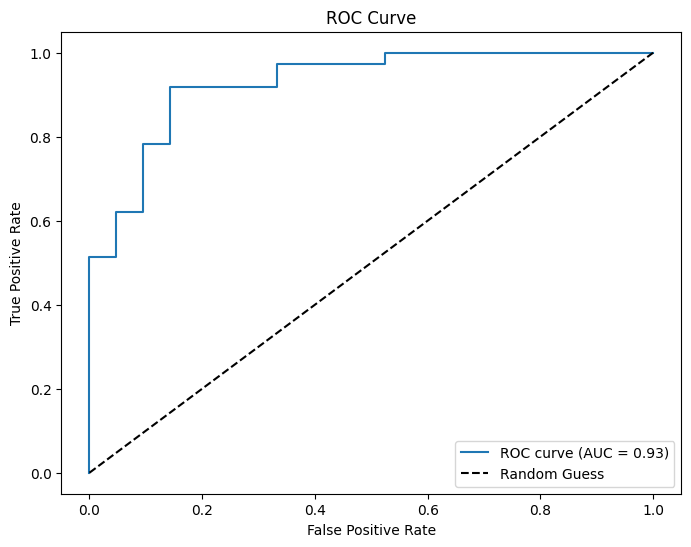

In [13]:

# ROC-кривая
y_pred_prob = logit_result.predict(X_const)
fpr, tpr, _ = roc_curve(y, y_pred_prob)
roc_auc = roc_auc_score(y, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## 11. Улучшение модели с помощью AIC

In [17]:

from statsmodels.tools.eval_measures import aic

# Улучшение модели
best_model = logit_result
best_aic = aic(llf=logit_result.llf, df_modelwc=logit_result.df_model, nobs=logit_result.nobs)

for i in range(1, len(X.columns)):
    candidate_X = X.iloc[:, :i]
    candidate_model = sm.Logit(y, add_constant(candidate_X)).fit(disp=False)
    candidate_aic = aic(llf=candidate_model.llf, df_modelwc=candidate_model.df_model, nobs=candidate_model.nobs)
    if candidate_aic < best_aic:
        best_model = candidate_model
        best_aic = candidate_aic

print("Лучшая модель по AIC:")
print(best_model.summary())


Лучшая модель по AIC:
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   58
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                            5
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.4779
Time:                        19:34:22   Log-Likelihood:                -19.824
converged:                       True   LL-Null:                       -37.967
Covariance Type:            nonrobust   LLR p-value:                 8.325e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9423      3.871     -2.827      0.005     -18.529      -3.356
x1             0.4555      0.180      2.529      0.011       0.102       0.809
x2             0.8085      0.4